# Учимся работе с данными - от загрузки до моделирования

In [20]:
import pandas as pd
import kagglehub
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")
path+='\\data.csv'
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Eugene\.cache\kagglehub\datasets\uciml\breast-cancer-wisconsin-data\versions\2\data.csv


In [21]:
data = pd.read_csv(path)

print("Базовые статистики для числовых признаков:")
print(data.describe())



Базовые статистики для числовых признаков:
                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
st

In [22]:
print("\nЦелевая переменная (diagnosis):")
print(data['diagnosis'].value_counts())




Целевая переменная (diagnosis):
diagnosis
B    357
M    212
Name: count, dtype: int64


In [23]:
print("\nПропорции:")
print(data['diagnosis'].value_counts(normalize=True))


Пропорции:
diagnosis
B    0.627417
M    0.372583
Name: proportion, dtype: float64


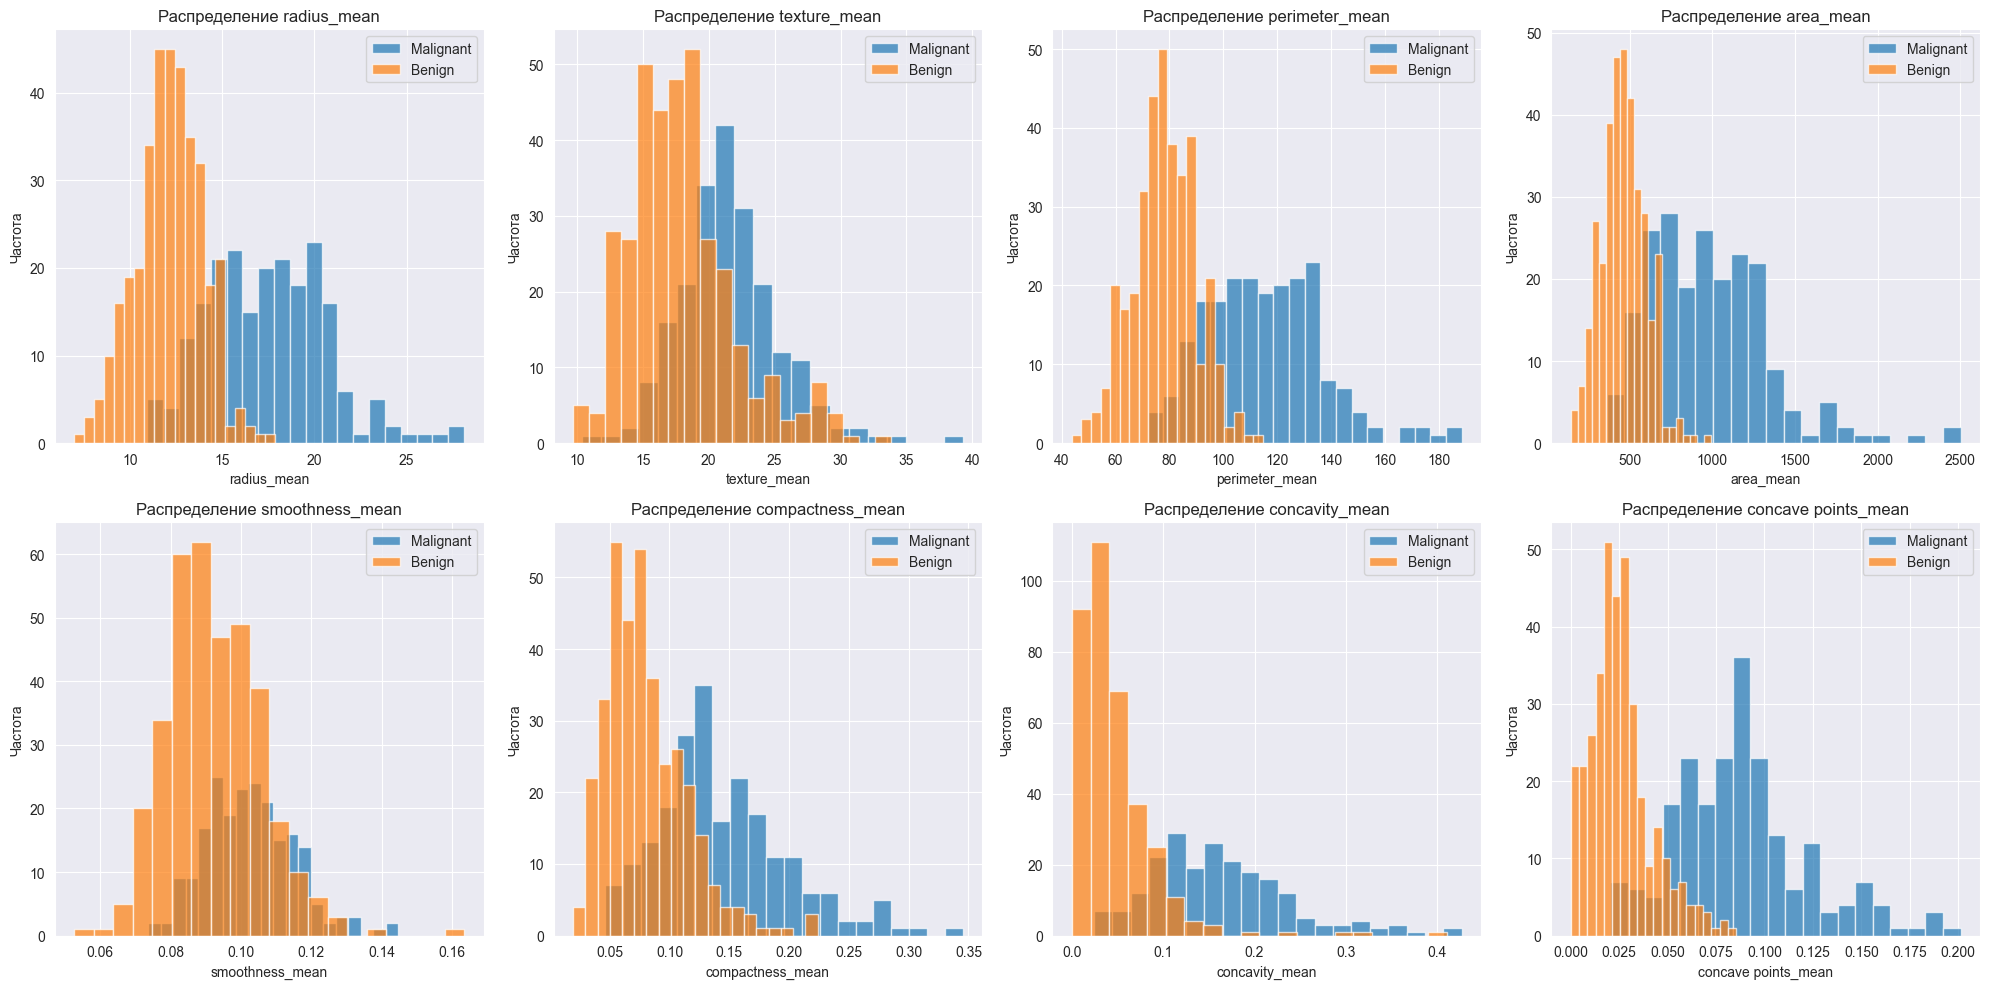

In [24]:
# Преобразование целевой переменной для лучшей визуализации
data['diagnosis'] = data['diagnosis'].map({'M': 'Malignant', 'B': 'Benign'})

# Гистограммы распределений признаков с группировкой по диагнозу
features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
           'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean']
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(features[:8]):
    for diagnosis_type in ['Malignant', 'Benign']:
        subset = data[data['diagnosis'] == diagnosis_type]
        axes[i].hist(subset[feature], alpha=0.7, label=diagnosis_type, bins=20)

    axes[i].set_title(f'Распределение {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Частота')
    axes[i].legend()

plt.tight_layout()
plt.show()

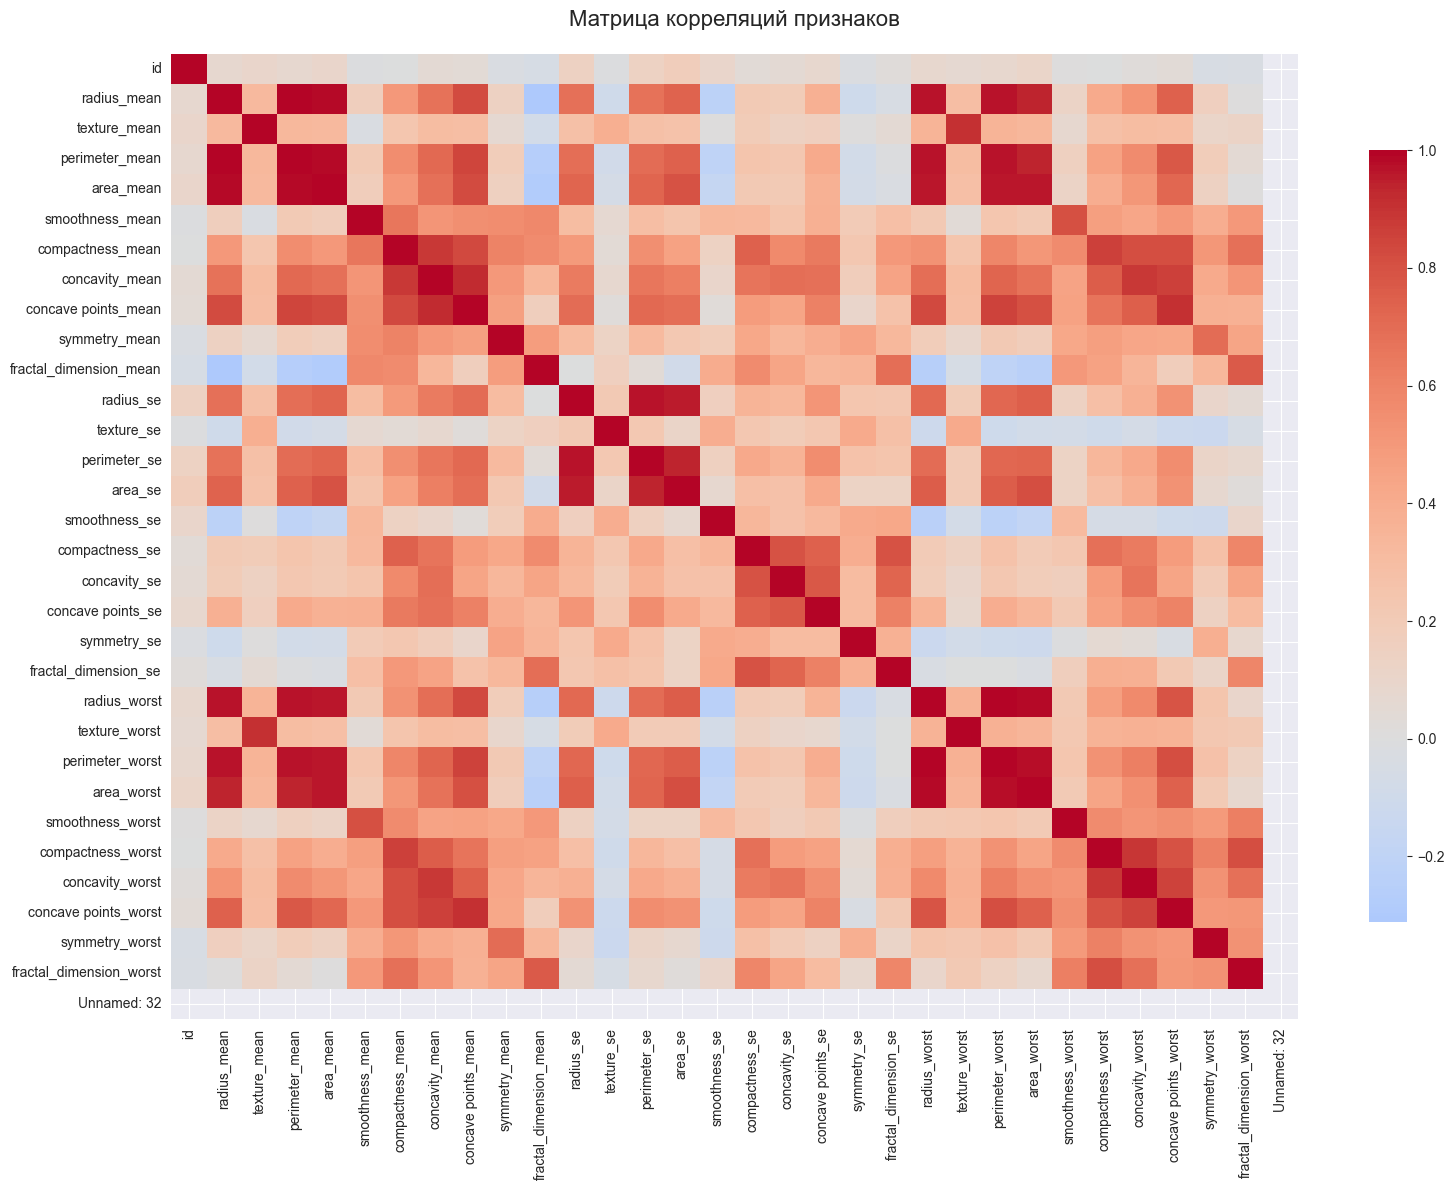

In [25]:
# Heatmap матрицы корреляций
# Выберем только числовые признаки для корреляций
numeric_cols = data.select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
           cbar_kws={'shrink': 0.8})
plt.title('Матрица корреляций признаков', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [26]:
# Найдем сильно скоррелированные признаки (коэффициент > 0.9)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print("Сильно скоррелированные пары признаков (|corr| > 0.9):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

Сильно скоррелированные пары признаков (|corr| > 0.9):
radius_mean - perimeter_mean: 0.998
radius_mean - area_mean: 0.987
radius_mean - radius_worst: 0.970
radius_mean - perimeter_worst: 0.965
radius_mean - area_worst: 0.941
texture_mean - texture_worst: 0.912
perimeter_mean - area_mean: 0.987
perimeter_mean - radius_worst: 0.969
perimeter_mean - perimeter_worst: 0.970
perimeter_mean - area_worst: 0.942
area_mean - radius_worst: 0.963
area_mean - perimeter_worst: 0.959
area_mean - area_worst: 0.959
concavity_mean - concave points_mean: 0.921
concave points_mean - concave points_worst: 0.910
radius_se - perimeter_se: 0.973
radius_se - area_se: 0.952
perimeter_se - area_se: 0.938
radius_worst - perimeter_worst: 0.994
radius_worst - area_worst: 0.984
perimeter_worst - area_worst: 0.978


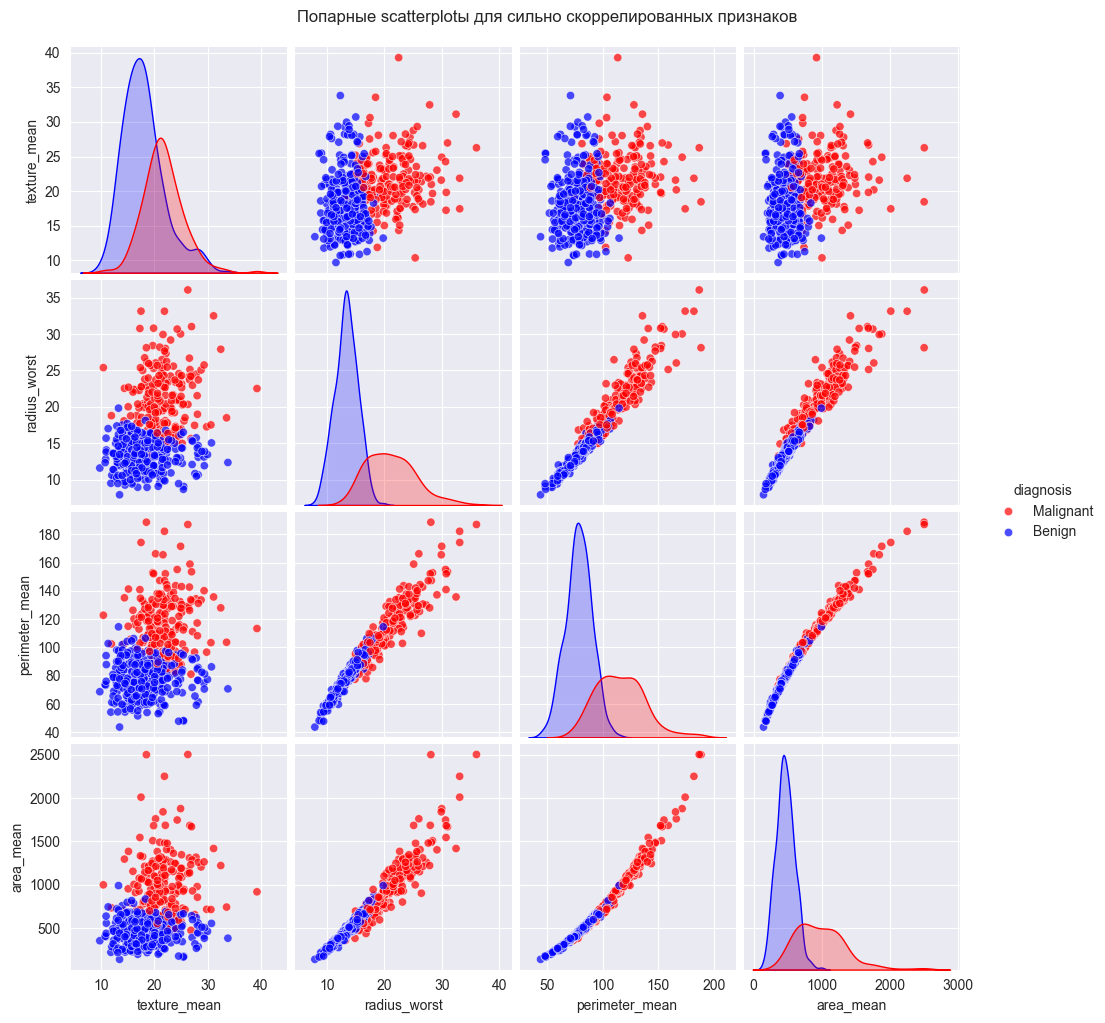

In [27]:
# Scatterplot для сильно скоррелированных признаков
high_corr_features = set()
for pair in high_corr_pairs[:6]:  # возьмем первые 6 пар
    high_corr_features.add(pair[0])
    high_corr_features.add(pair[1])

high_corr_features = list(high_corr_features)[:4]  # возьмем 4 признака для визуализации


scatter_df = data[high_corr_features + ['diagnosis']]
sns.pairplot(scatter_df, hue='diagnosis', palette={'Malignant': 'red', 'Benign': 'blue'},
            plot_kws={'alpha': 0.7})
plt.suptitle('Попарные scatterplotы для сильно скоррелированных признаков', y=1.02)
plt.show()

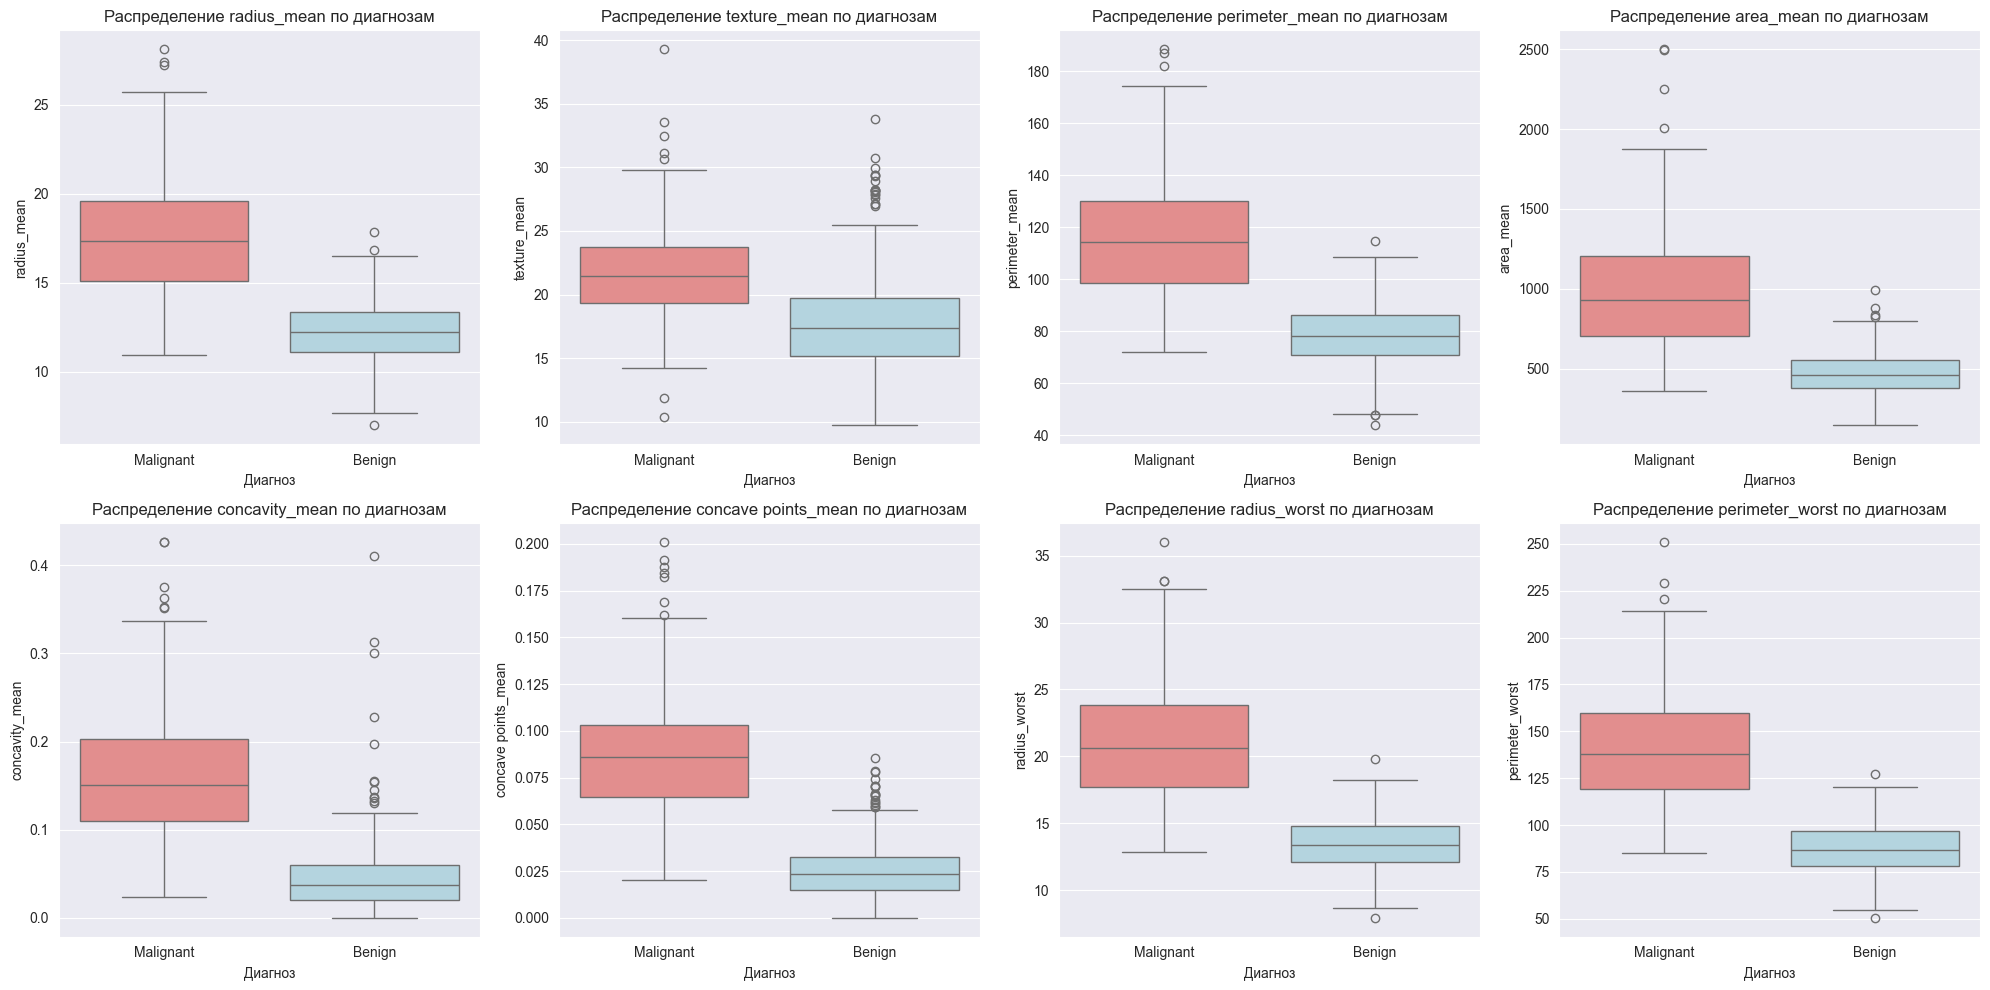

In [28]:
# Boxplots для анализа различий между классами
# Выберем наиболее информативные признаки
key_features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
               'concavity_mean', 'concave points_mean', 'radius_worst', 'perimeter_worst']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    sns.boxplot(data=data, x='diagnosis', y=feature, ax=axes[i],
               palette={'Malignant': 'lightcoral', 'Benign': 'lightblue'})
    axes[i].set_title(f'Распределение {feature} по диагнозам')
    axes[i].set_xlabel('Диагноз')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

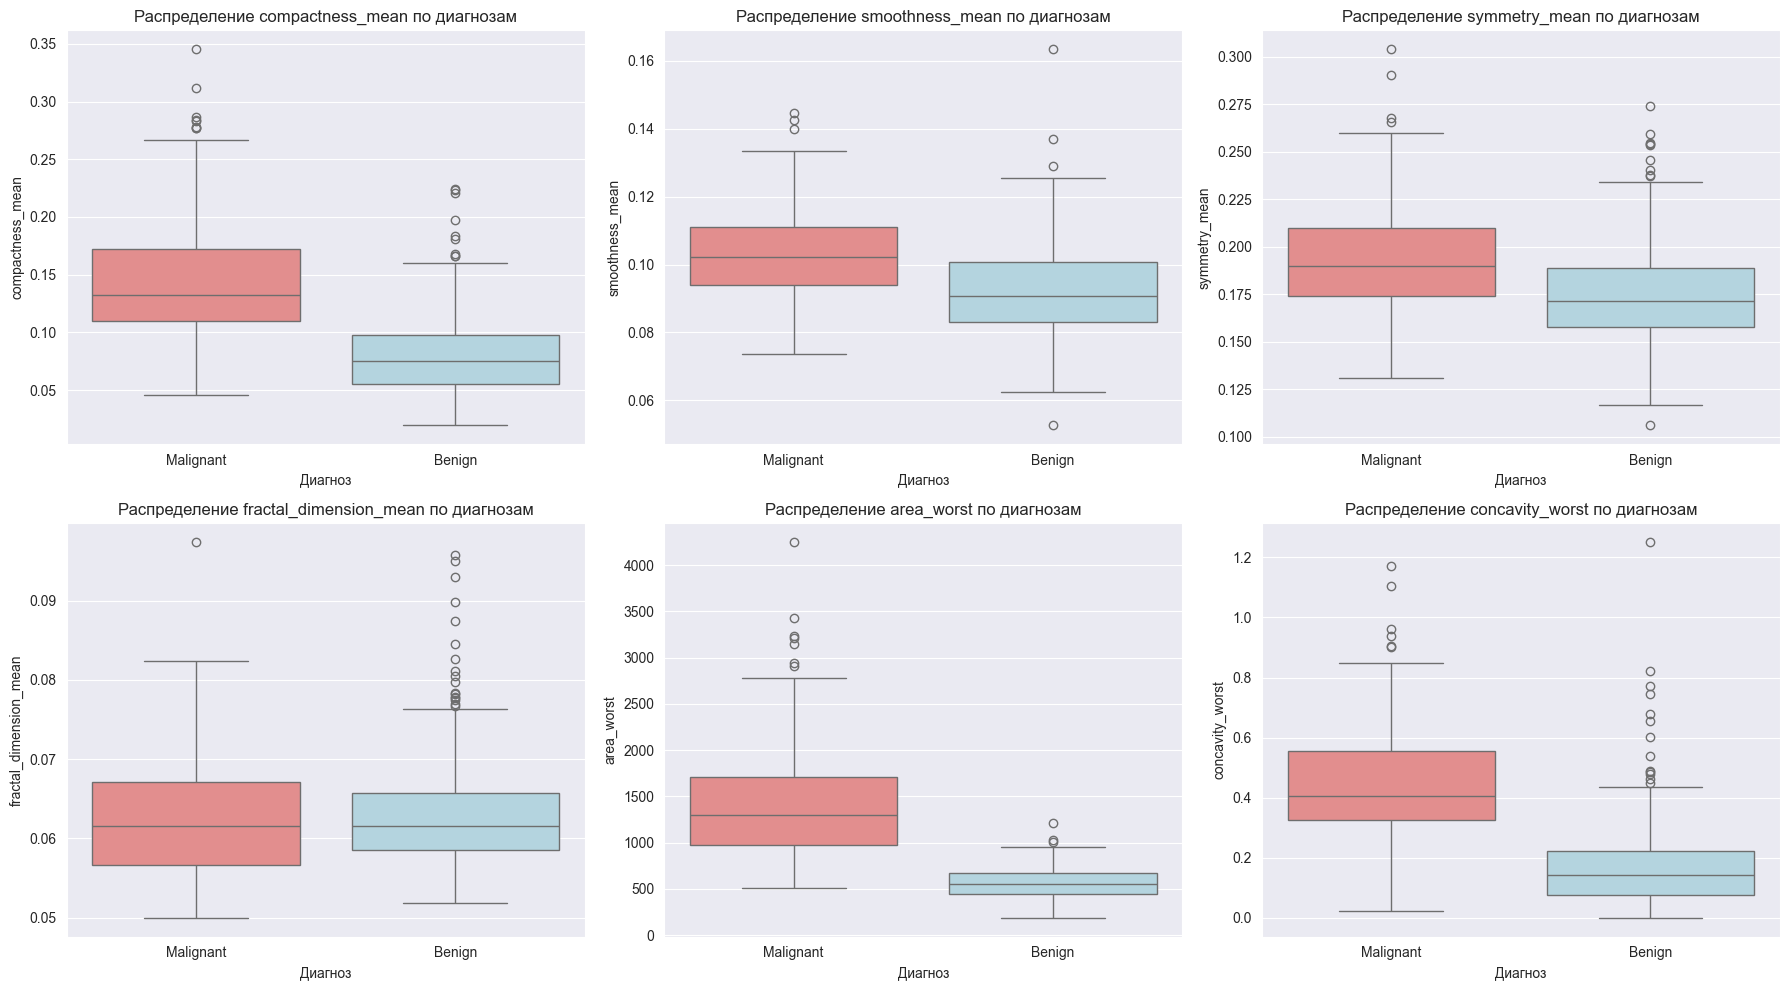

In [29]:
# Дополнительные boxplots для других важных признаков
more_features = ['compactness_mean', 'smoothness_mean', 'symmetry_mean',
                'fractal_dimension_mean', 'area_worst', 'concavity_worst']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, feature in enumerate(more_features):
    sns.boxplot(data=data, x='diagnosis', y=feature, ax=axes[i],
               palette={'Malignant': 'lightcoral', 'Benign': 'lightblue'})
    axes[i].set_title(f'Распределение {feature} по диагнозам')
    axes[i].set_xlabel('Диагноз')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

In [30]:
# Количественный анализ различий между классами
malignant = data[data['diagnosis'] == 'Malignant']
benign = data[data['diagnosis'] == 'Benign']

print("Средние значения по классам для ключевых признаков:")
key_features_extended = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
                        'concavity_mean', 'concave points_mean', 'radius_worst', 'perimeter_worst']

comparison_df = pd.DataFrame({
    'Feature': key_features_extended,
    'Malignant_Mean': [malignant[feat].mean() for feat in key_features_extended],
    'Benign_Mean': [benign[feat].mean() for feat in key_features_extended],
    'Difference': [malignant[feat].mean() - benign[feat].mean() for feat in key_features_extended],
    'Diff_Percent': [((malignant[feat].mean() - benign[feat].mean()) / benign[feat].mean() * 100)
                    for feat in key_features_extended]
})

comparison_df['Diff_Percent'] = comparison_df['Diff_Percent'].round(1)
print(comparison_df.sort_values('Diff_Percent', key=abs, ascending=False))

Средние значения по классам для ключевых признаков:
               Feature  Malignant_Mean  Benign_Mean  Difference  Diff_Percent
4       concavity_mean        0.160775     0.046058    0.114717         249.1
5  concave points_mean        0.087990     0.025717    0.062273         242.1
3            area_mean      978.376415   462.790196  515.586219         111.4
7      perimeter_worst      141.370330    87.005938   54.364392          62.5
6         radius_worst       21.134811    13.379801    7.755010          58.0
2       perimeter_mean      115.365377    78.075406   37.289971          47.8
0          radius_mean       17.462830    12.146524    5.316306          43.8
1         texture_mean       21.604906    17.914762    3.690144          20.6


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc


df_filled = data.fillna(0)


X = df_filled.drop([ 'diagnosis'], axis=1)
y = df_filled['diagnosis']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 398
Test size: 171


In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Базовый kNN (без настройки):
Accuracy: 0.965
Precision: 1.000
Recall: 0.906
F1-score: 0.951


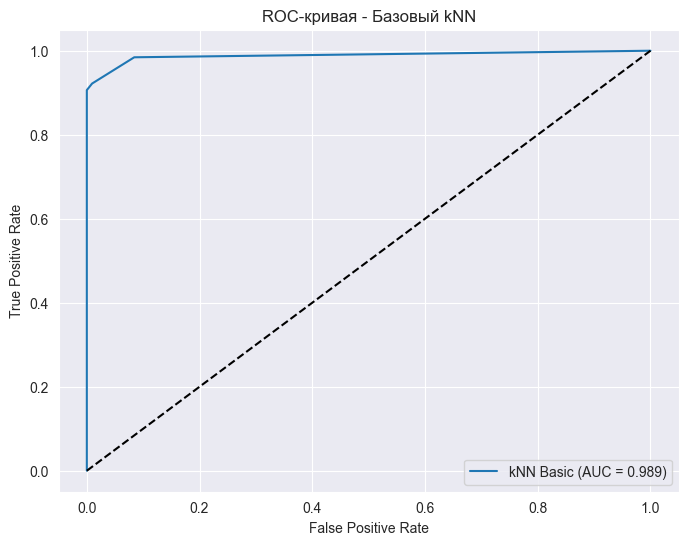

In [33]:
knn_basic = KNeighborsClassifier()
knn_basic.fit(X_train_scaled, y_train)
y_pred_basic = knn_basic.predict(X_test_scaled)
y_pred_proba_basic = knn_basic.predict_proba(X_test_scaled)[:, 1]

# Метрики качества
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Базовый kNN (без настройки):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_basic):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_basic, pos_label='Malignant'):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_basic, pos_label='Malignant'):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred_basic, pos_label='Malignant'):.3f}")

# ROC-кривая
fpr_basic, tpr_basic, _ = roc_curve(y_test, y_pred_proba_basic, pos_label='Malignant')
roc_auc_basic = auc(fpr_basic, tpr_basic)

plt.figure(figsize=(8, 6))
plt.plot(fpr_basic, tpr_basic, label=f'kNN Basic (AUC = {roc_auc_basic:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая - Базовый kNN')
plt.legend()
plt.show()

Лучший параметр: {'n_neighbors': 7}
Лучшая точность на кросс-валидации: 0.970

Настроенный kNN:
Accuracy: 0.965
Precision: 1.000
Recall: 0.906
F1-score: 0.951


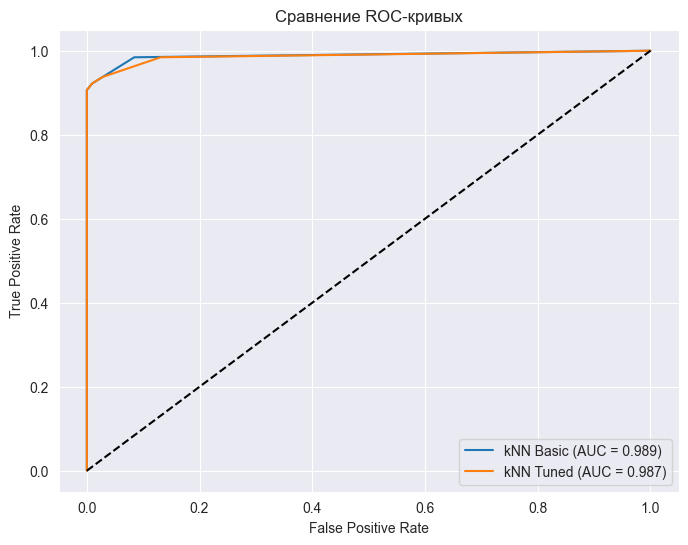

In [34]:
from sklearn.model_selection import GridSearchCV

# Подбор оптимального числа соседей
param_grid = {'n_neighbors': range(1, 31)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print(f"Лучший параметр: {grid_search.best_params_}")
print(f"Лучшая точность на кросс-валидации: {grid_search.best_score_:.3f}")

# Оценка на тестовой выборке
knn_tuned = grid_search.best_estimator_
y_pred_tuned = knn_tuned.predict(X_test_scaled)
y_pred_proba_tuned = knn_tuned.predict_proba(X_test_scaled)[:, 1]

print("\nНастроенный kNN:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_tuned, pos_label='Malignant'):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_tuned, pos_label='Malignant'):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred_tuned, pos_label='Malignant'):.3f}")

# Сравнение ROC-кривых
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_proba_tuned, pos_label='Malignant')
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

plt.figure(figsize=(8, 6))
plt.plot(fpr_basic, tpr_basic, label=f'kNN Basic (AUC = {roc_auc_basic:.3f})')
plt.plot(fpr_tuned, tpr_tuned, label=f'kNN Tuned (AUC = {roc_auc_tuned:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC-кривых')
plt.legend()
plt.show()